# Zero shot image classification

In [9]:
import os
from transformers import pipeline
from PIL import Image
import time
import matplotlib.pyplot as plt
import os
import cv2
from transformers import pipeline
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Zero-shot image classification pipeline

The simplest way to try out inference with a model supporting zero-shot image classification is to use the corresponding [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline).
Instantiate a pipeline from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads):

In [3]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification", device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [4]:
import zipfile
import os

zip_file_name = '/content/raw.zip'

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [37]:
image_folder = '/content/raw'
candidate_labels = ["teacher teaching", "students standing", "student fight", "teacher punishing students", "teacher using mobile", "teacher checking notebook"]

In [28]:
def process_video(video_path, candidate_labels, fps=1, threshold=0.5):
    """
    Process video file and detect specified activities
    Args:
        video_path: Path to video file
        fps: Frames per second to process (default: 1)
        threshold: Confidence threshold for detection (default: 0.5)
    """
    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)  # Calculate frame interval based on desired fps

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process only frames at specified interval
        if frame_count % frame_interval == 0:
            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for CLIP model
            pil_image = Image.fromarray(rgb_frame)

            # Get predictions
            predictions = detector(pil_image, candidate_labels=candidate_labels)

            # Check if any prediction exceeds threshold
            for pred in predictions:
                if pred['score'] > threshold:
                    # Plot the frame and prediction
                    plt.figure(figsize=(10, 6))
                    plt.imshow(rgb_frame)
                    plt.title(f"Detected: {pred['label']} ({pred['score']:.2f})")
                    plt.axis('off')
                    plt.show()
                    print(f"Frame {frame_count}: {pred['label']} {pred['score']:.4f}")

        frame_count += 1

    cap.release()

In [34]:
def process_dataset(dataset_path, candidate_labels, threshold):
    """
    Process all videos in the dataset
    Args:
        dataset_path: Path to dataset folder
    """
    # Extract dataset if it's a zip file
    if dataset_path.endswith('.zip'):
        import zipfile
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            extract_path = os.path.splitext(dataset_path)[0]
            zip_ref.extractall(extract_path)
            dataset_path = extract_path

    # Process all video files
    video_extensions = ('.mp4', '.avi', '.mov', '.mkv')
    for filename in os.listdir(dataset_path):
        if filename.lower().endswith(video_extensions):
            video_path = os.path.join(dataset_path, filename)
            print(f"\nProcessing video: {filename}")
            process_video(video_path, candidate_labels, fps=1, threshold=threshold)


Processing video: 6cf17439-0b88-42d9-b249-6c5033878aca.mp4


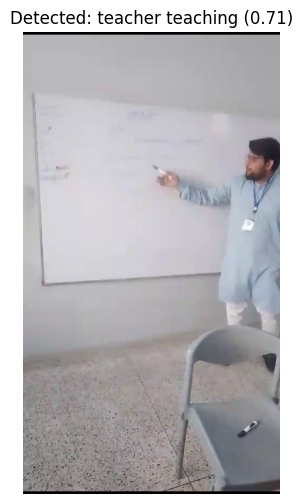

Frame 30: teacher teaching 0.7119

Processing video: 641eea67-21ed-4b69-8fd6-b0f2817d25b4.mp4


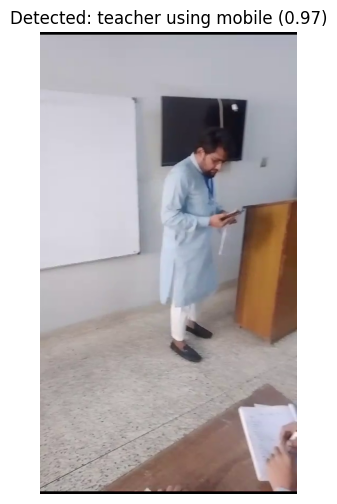

Frame 450: teacher using mobile 0.9723


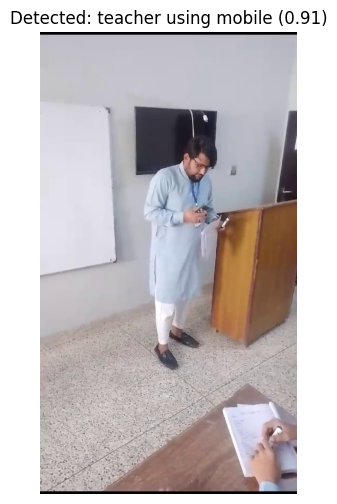

Frame 480: teacher using mobile 0.9091


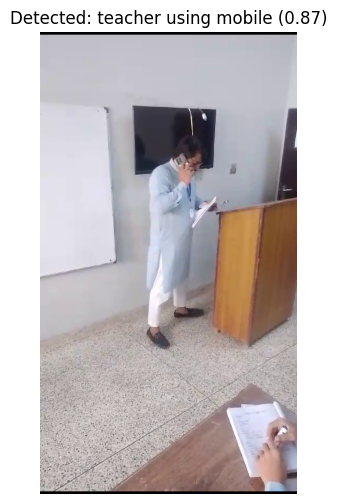

Frame 510: teacher using mobile 0.8723

Processing video: aa7c9f19-73a4-448f-9bdf-c1869e1809ad.mp4


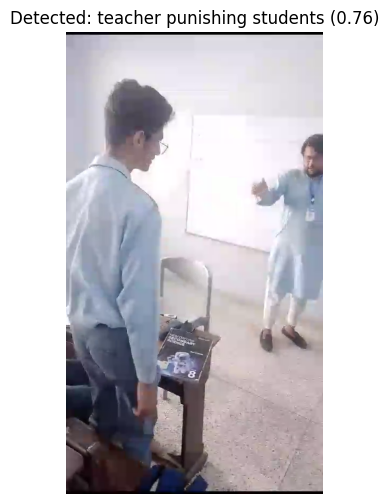

Frame 60: teacher punishing students 0.7645


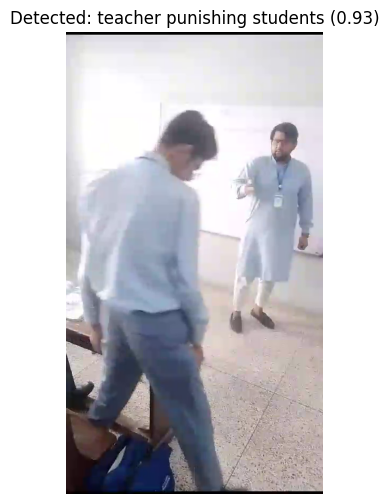

Frame 90: teacher punishing students 0.9259


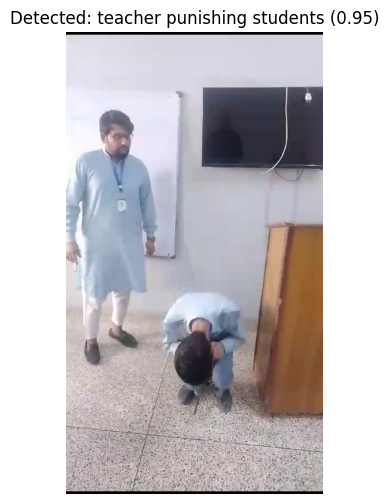

Frame 240: teacher punishing students 0.9502

Processing video: 0B453FD9-7913-4109-A2C4-33A90896DC36.mp4


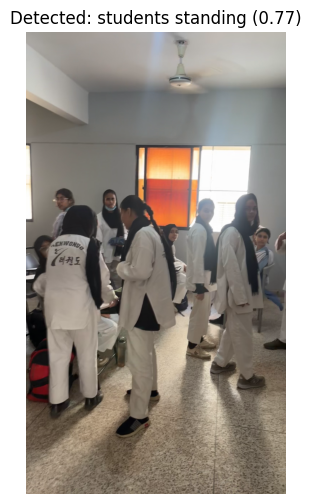

Frame 116: students standing 0.7698

Processing video: 4489c5d4-a3d9-49d7-9c38-abbef381f8c9.mp4

Processing video: 2850FABB-68AD-489D-BD1A-151ECBC5AAD8.mp4


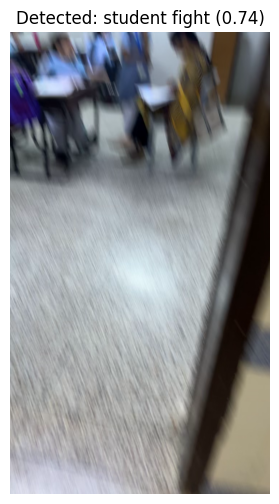

Frame 0: student fight 0.7408

Processing video: 84f91962-955f-4cf6-985a-3b6d180ac7b4.mp4

Processing video: 221b9d0a-2a87-4834-be4d-1b53c5c7fa3a.mp4


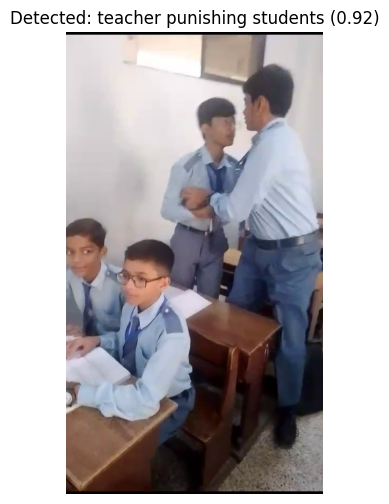

Frame 150: teacher punishing students 0.9237


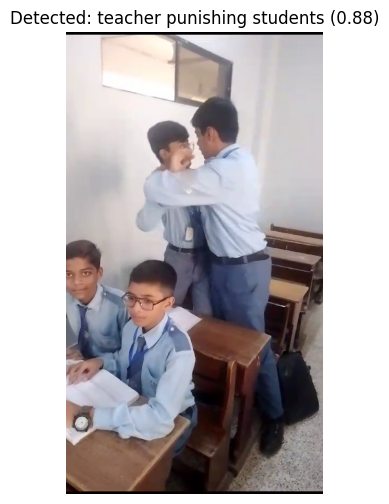

Frame 180: teacher punishing students 0.8777


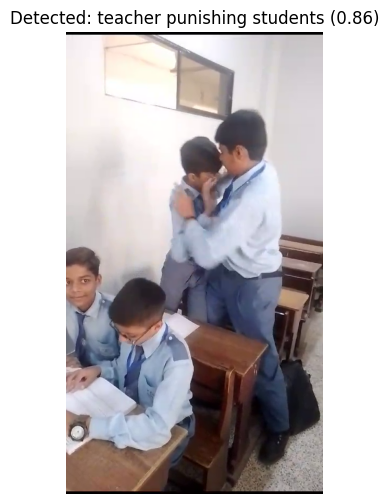

Frame 210: teacher punishing students 0.8632

Processing video: 3B5CD63C-DD90-467C-8C8B-BBA37099E5B3.mp4

Processing video: 52B7ACAE-D814-406E-AB6A-2CB19068A014.mp4


In [38]:
dataset_path = '/content/raw.zip'
process_dataset(dataset_path, candidate_labels, threshold=0.7)